### Stock Forecaster Test 2

In [1]:
from lib.forecast2 import StockForecast
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime
from lib.scraper import StockScraper

In [2]:
scraper = StockScraper("SPY", interval="1h", period="2y")
scraper.from_yahoo()
scraper.data.shape, scraper.data.columns

((3513, 8),
 Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
        'Capital Gains'],
       dtype='object'))

<Axes: xlabel='Datetime'>

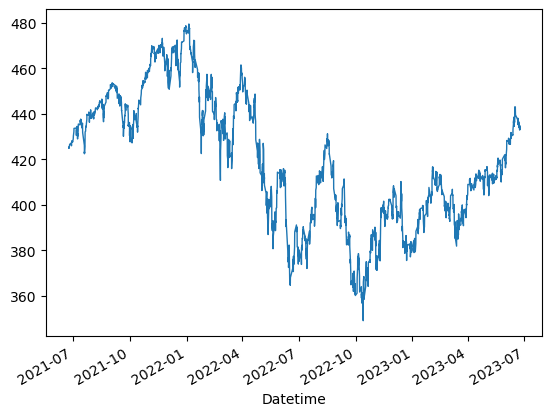

In [3]:
scraper.data["Open"].plot(linewidth=1)

In [4]:
train_on = ["Open", "Volume", "Close"]
target = ["Close"]
chart_train_column = 0

sf = StockForecast(
    epochs=400,lr=0.001, 
    num_prediction_seq=10, num_training_seq=100,
    hidden_size=5, 
    gpu_device="mps", 
    train_on=train_on, target=target
)

sf.load(scraper.data, start_at = 0)
sf.normalize()
sf.sequence(batch_size=10, shuffle=True)
sf.create_model()

In [5]:
sf.total_samples, sf.X_train.shape[0]

(3513, 3513)

In [ ]:
train_loss, test_loss = sf.train(debug_freq=25)

Epoch: 0, train loss: 0.02990310290505732, test loss: 0.0006955119277133943
Epoch: 25, train loss: 0.0015426384075088245, test loss: 0.0006281670123118804
Epoch: 50, train loss: 0.0014957670716635786, test loss: 0.0005662834163457672
Epoch: 75, train loss: 0.0014718326417922523, test loss: 0.0005966086010731589
Epoch: 100, train loss: 0.0014441753066147928, test loss: 0.000566265613290145
Epoch: 125, train loss: 0.0014353177657242852, test loss: 0.000621856657138172
Epoch: 150, train loss: 0.0014065519432549431, test loss: 0.0006979352603795835
Epoch: 175, train loss: 0.0014265024450758252, test loss: 0.0005909934973007896
Epoch: 200, train loss: 0.0013506617519286996, test loss: 0.000557926883225769
Epoch: 225, train loss: 0.001356273319448947, test loss: 0.0006191211472873369
Epoch: 250, train loss: 0.0012961546353062955, test loss: 0.0006044254955163018
Epoch: 275, train loss: 0.0012863178034023886, test loss: 0.0006073333485498248
Epoch: 300, train loss: 0.0012818898939454526, test

#### Train Model

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="loss", linewidth=0.5)
plt.plot(test_loss, label="test loss", linewidth=0.5)
plt.legend()

plt.show()

#### Validate

In [ ]:
output = sf.lstm(sf.test_dataset.data)

out_scale = sf.mm.inverse_transform(output[:].detach().numpy())
train_set = sf.rs.inverse_transform(sf.test_dataset.data[:,-1])

plt.plot(train_set[:, 0], label="actual", alpha=0.5, linewidth=1)
plt.plot(out_scale[:, -1], label="predict", linewidth=1)
plt.legend()
plt.show()

In [ ]:
sf.test_dataset.data.size(), out_scale.size / len(out_scale)

In [ ]:
actual = sf.rs.inverse_transform(sf.test_dataset.data[:,-1])[:,0][-50:]
predict = out_scale[:,-1].tolist()[-50:]
future = [None] * (len(predict)-1)
future.extend(out_scale[-1,:].tolist())
plt.plot(actual, label="actual", linewidth=1)
plt.plot(predict, label="predict", linewidth=1)
plt.plot(future, label="future", linewidth=1)
plt.legend()
plt.show()